# **eXponential FAmily Dynamical Systems (XFADS): Large-scale nonlinear Gaussian state-space modeling**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/catniplab/latent_dynamics_workshop/blob/main/04_xfads_mc_maze_demo.ipynb)

A structured variational autoencoding framework for nonlinear state-space models capable of capturing dense covariance structures that are important for learning dynamical systems with predictive capabilities. Furthermore, when applied to neural recordings, our approach is able to learn a dynamical system capable of forecasting population spiking and behavioral correlates from a small portion of a single trial.

To infer latent trajectories, XFADS leverages some quintessential properties of the exponential family distributions.

This is a walk-through of some of the core functions of XFADS applied to spiking neural recordings. We will be building and training a state-space model of the [MC_Maze](https://neurallatents.github.io/datasets.html) dataset as a benchmark, which is a delayed center-out reaching task with obstructing barriers forming a maze, resulting in a variety of straight and curved reaches.

With adequate configs and suitable choices of distributions for the SSM modules (as we will see below), you can fit XFADS on different spans of neural data.<br>

[Dowling, Zhao, Park. 2024](https://arxiv.org/abs/2403.01371).

In [3]:
try:
    import google.colab
    _in_colab = True
except:
    _in_colab = False

# Installation

Create a `build-system` for the `xfads` package from the `pyproject.toml`

(If you are local, make sure to run this command in the terminal after cd'íng to the project/ workshop main directory and activating the conda environment)

`pip install -e xfads/`

In [5]:
if _in_colab:
    !git clone --recurse-submodules https://github.com/catniplab/latent_dynamics_workshop.git

In [6]:
import sys
import os

cwd = os.getcwd()
if _in_colab:
    sys.path.append(os.path.join(cwd, "latent_dynamics_workshop"))
    sys.path.append(os.path.join(cwd, "latent_dynamics_workshop/xfads"))

In [7]:
if _in_colab:
    !pip install -e latent_dynamics_workshop/xfads/

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA

import torch
import pytorch_lightning as lightning

import warnings
warnings.filterwarnings("ignore") # matplotlib

# Model and training parameters configuration

In [10]:
"""config"""

cfg = {
    # --- graphical model --- #
    'n_latents': 40,
    'n_latents_read': 35,

    'rank_local': 15,
    'rank_backward': 5,

    'n_hidden_dynamics': 128,

    # --- inference network --- #
    'n_samples': 25,
    'n_hidden_local': 256,
    'n_hidden_backward': 128,

    # --- hyperparameters --- #
    'use_cd': False,
    'p_mask_a': 0.0,
    'p_mask_b': 0.0,
    'p_mask_apb': 0.0,
    'p_mask_y_in': 0.0,
    'p_local_dropout': 0.4,
    'p_backward_dropout': 0.0,

    # --- training --- #
    'device': 'cpu',
    'data_device': 'cpu',

    'lr': 1e-3,
    'lr_gamma_decay': 0.997,
    'n_epochs': 3,
    'batch_sz': 128,

    # --- misc --- #
    'bin_sz': 20e-3,
    'bin_sz_ms': 20,

    'seed': 1234,
    'default_dtype': torch.float32,
}

class Cfg(dict):
    def __getattr__(self, attr):
        if attr in self:
            return self[attr]
        else:
            raise AttributeError(f"'DictAsAttributes' object has no attribute '{attr}'")

cfg = Cfg(cfg)

if not torch.cuda.is_available():
    cfg.device = 'cpu'
    cfg.data_device = 'cpu'

lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

if cfg.device == 'cuda':
    torch.cuda.empty_cache()

Seed set to 1234


# Load the data

<p align="center">
  <img src="https://github.com/catniplab/latent_dynamics_workshop/blob/main/img/maze.png?raw=1"/>
</p>

**Neural activity:**
- Binned at 20 ms
- Covers 45 bins per trial
- Time window: -240 ms to +660 ms relative to movement onset

**Kinematics (hand velocity):**
- binned at 20 ms
- Covers 35 bins per trial
- Time window: -40 ms to +660 ms relative to movement onset

In [12]:
data_splits_path = './xfads/examples/monkey_reaching/data' if not _in_colab else 'latent_dynamics_workshop/xfads/examples/monkey_reaching/data'

train_data = torch.load(data_splits_path + f'/data_train_{cfg.bin_sz_ms}ms.pt')
valid_data = torch.load(data_splits_path + f'/data_valid_{cfg.bin_sz_ms}ms.pt')
test_data = torch.load(data_splits_path + f'/data_test_{cfg.bin_sz_ms}ms.pt')

train_data.keys()

dict_keys(['y_obs', 'velocity', 'n_neurons_enc', 'n_neurons_obs', 'n_time_bins_enc'])

In [13]:
y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_valid_obs = valid_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)

vel_train = train_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_valid = valid_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_test = test_data['velocity'].type(torch.float32).to(cfg.data_device)

print(y_train_obs.shape) # trials x time bins x neurons
print(vel_valid.shape) # trials x time bins x vx, vy
print(vel_test.shape)

torch.Size([1721, 45, 182])
torch.Size([287, 35, 2])
torch.Size([287, 35, 2])


In [14]:
def plot_single_reaches(reaches, n_trials_to_plot):
    trial_plt_dx = torch.randperm(reaches.shape[0])[:n_trials_to_plot]

    fig = plt.figure(figsize=(5, 5))
    fig.suptitle('hand reaches')
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    ax.axis('off')

    for n in trial_plt_dx:
        traj = torch.cumsum(reaches[n], dim=0)
        reach_angle = torch.atan2(traj[-1, 0], traj[-1, 1])
        reach_color = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)
        
        ax.plot(traj[:, 0], traj[:, 1], linewidth=1.0, alpha=0.8, color=reach_color)

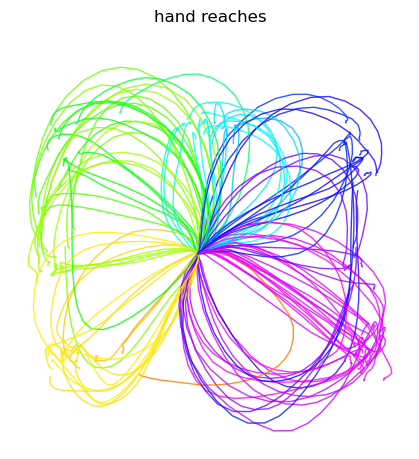

In [15]:
plot_single_reaches(vel_train.cpu(), n_trials_to_plot=120)

In [16]:
move_onset_bin = 12

# at t=bin_prd_start start forecast
bin_prd_start = 10

_, n_bins, n_neurons_obs = y_train_obs.shape
n_bins_prd = n_bins - bin_prd_start

n_bins_enc = train_data['n_time_bins_enc']

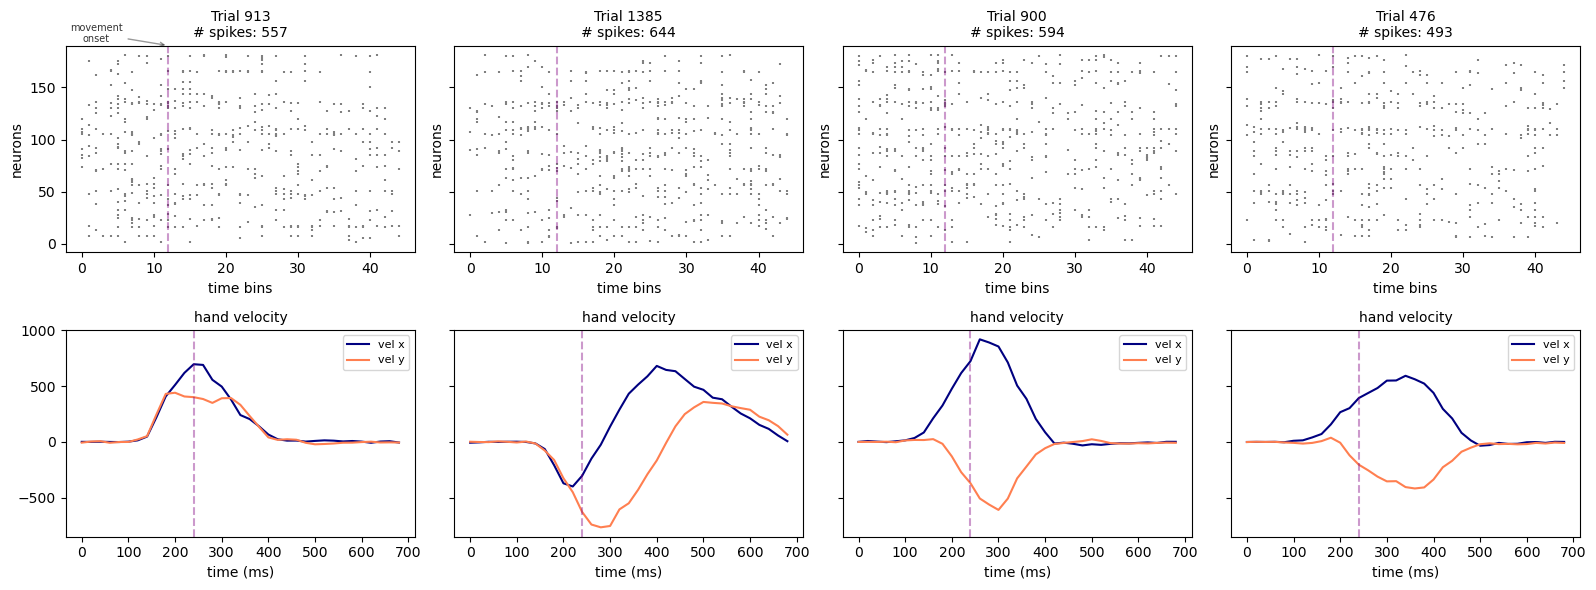

In [17]:
def plot_spikes_and_behavior(spikes, velocity, binsize, trials_inds, event_bin):
    n_trials = len(trials_inds)
    fig, axes = plt.subplots(nrows=2, ncols=n_trials, figsize=(4 * n_trials, 6), sharex=False, sharey='row')
    if n_trials == 1:
        axes = axes.reshape(2, 1)

    for col, trial_idx in enumerate(trials_inds):
        trial = spikes[trial_idx]
        reach = velocity[trial_idx]
        ax_spikes = axes[0, col]
        ax_vel = axes[1, col]

        for neuron_idx in range(trial.shape[-1]):
            spike_times = np.where(trial[:, neuron_idx].cpu() == 1)[0]
            ax_spikes.scatter(spike_times, [neuron_idx] * len(spike_times), s=4, color='gray', marker='|')

        ax_spikes.axvline(x=event_bin, linestyle='--', color='purple', alpha=0.4)
        ax_spikes.set_ylabel('neurons')
        ax_spikes.set_title(f'Trial {trial_idx}\n# spikes: {int(torch.sum(trial))}', fontsize=10)
        ax_spikes.set_xlabel('time bins')

        time_axis = torch.arange(reach.shape[0]) * binsize
        ax_vel.plot(time_axis, reach[:, 0], color='navy', label='vel x')
        ax_vel.plot(time_axis, reach[:, 1], color='coral', label='vel y')
        ax_vel.axvline(x=event_bin * binsize, linestyle='--', color='purple', alpha=0.4)
        ax_vel.set_xlabel('time (ms)')
        ax_vel.set_title('hand velocity', fontsize=10)
        ax_vel.legend(fontsize=8)

        if col == 0:
            _, y_top = ax_spikes.get_ylim()
            ax_spikes.annotate("movement\nonset", xy=(event_bin, y_top), xytext=(event_bin - 10, y_top + 3),
                               arrowprops=dict(facecolor='black', alpha=0.4, arrowstyle='->'),
                               fontsize=7, ha='center', alpha=0.8)

    fig.tight_layout()
    plt.show()


plot_spikes_and_behavior(y_train_obs.cpu(), vel_train.cpu(), cfg.bin_sz_ms,
                         torch.randperm(y_train_obs.size(0))[:4],
                         event_bin=move_onset_bin,)

In [18]:
"""prepare data for torch"""
y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, vel_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, vel_valid)
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, vel_test)

train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_val_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)
test_dataloader = torch.utils.data.DataLoader(y_test_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)

# Building the State Space Model

The basic elements of any state space model are:<br>
- **Dynamics Model**, i.e. the stochastic differential equation that governs how the latents (state variables) evolve over time.
- **Observations Model**, i.e. the data likelihood, given the latents, that governs how the state variables can generate corresponding observations.

The modules to build up the state space model, to be learned by XFADS, are organized as Python classes, in a way allowing users to change and plug in their own classes that structure the elements of the model, i.e. the dynamics function, the likelihood density, and the inference network. The configuration depends on the problem: `dynamics_mod`, `initial_c_pdf`, `likelihood_pdf`, `local_encoder`, and `backward_encoder` can be configured as desired. We include some general classes in `ssm_modules/encoders`, `ssm_modules/likelihoods`, and `ssm_modules/dynamics` that should be sufficient for a wide range of problems.  Below is an example configuration.

In each iteration of the Variational Inference, we need to optimize the parameters of the approximate posterior, which can be quite inefficient,

To amortize the computational cost at inference time, we follow the technique of using a trainable NN, known as an **inference network** (a.k.a recognition model or "encoder") that outputs the posterior from the observed data.

A possible drawback of the typical sequential VAEs is that they cannot naturally handle missing observations. To enable the amortized inference network to process missing observations in a principled way, we decompose the natural parameter update, of the approximate posterior, into two additive components (explained, and the intuition behind it, more in the next step). We use missing observations when masking time to encourage better forecasting.

For a detailed building of XFADS, check the Method section of [the paper](https://arxiv.org/abs/2403.01371).

<p align="center">
  <img src="https://github.com/catniplab/latent_dynamics_workshop/blob/main/img/ssm_diagram.png?raw=1" width=1000/>
</p><p align="center">

In [20]:
import torch.nn as nn

from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import RichProgressBar, ModelCheckpoint

import xfads.utils as utils
import xfads.prob_utils as prob_utils
import xfads.plot_utils as plot_utils

from xfads.smoothers.nonlinear_smoother_causal import LowRankNonlinearStateSpaceModel, NonlinearFilter
from xfads.ssm_modules.dynamics import DenseGaussianDynamics, DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.ssm_modules.likelihoods import PoissonLikelihood

from xfads.smoothers.lightning_trainers import LightningMonkeyReaching

`smoothers.lightning_trainers` provides PyTorch Lightning modules for fitting state-space models to neural population activity, with support for our structured variational inference, input-driven latent dynamics, and temporally scheduled masking of observations. These modules standardize training, validation, and testing workflows, including log-likelihood computation, bits-per-spike metrics, and linear decoding of behavior from inferred firing rates or latent states.

The `LightningMonkeyReaching` class is tailored for the MC Maze task, combining spiking and kinematic data from non-human primates. It supports masked training for robust inference, forward prediction from partial observations, and model selection based on R² scores from decoding hand velocity, enabling evaluation of both latent representation quality and predictive performance.

In [22]:
if cfg.device == 'cuda':
    torch.cuda.empty_cache()

"""likelihood module"""
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, nn.Linear(cfg.n_latents_read, n_neurons_obs))
likelihood_pdf = PoissonLikelihood(readout_fn, n_neurons_obs, cfg.bin_sz, device=cfg.device)

"""dynamics module"""
Q_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

"""initial condition"""
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)
Q_0_diag = 1. * torch.ones(cfg.n_latents, device=cfg.device)
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

"""local/backward encoder"""
backward_encoder = BackwardEncoderLRMvn(cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
                                        rank_local=cfg.rank_local, rank_backward=cfg.rank_backward,
                                        device=cfg.device)
local_encoder = LocalEncoderLRMvn(cfg.n_latents, n_neurons_obs, cfg.n_hidden_local, cfg.n_latents,rank=cfg.rank_local,
                                  device=cfg.device, dropout=cfg.p_local_dropout)

"""nonlinear filter"""
nl_filter = NonlinearFilter(dynamics_mod, initial_condition_pdf, device=cfg.device)

"""sequential vae"""
ssm = LowRankNonlinearStateSpaceModel(dynamics_mod, likelihood_pdf, initial_condition_pdf, backward_encoder,
                                      local_encoder, nl_filter, device=cfg.device)

seq_vae = LightningMonkeyReaching(ssm, cfg, n_bins_enc, bin_prd_start)
seq_vae.eval()

LightningMonkeyReaching(
  (ssm): LowRankNonlinearStateSpaceModel(
    (nl_filter): NonlinearFilter(
      (dynamics_mod): DenseGaussianDynamics(
        (mean_fn): DynamicsGRU(
          (gru_cell): GRUCell(0, 128)
          (h_to_z): Linear(in_features=128, out_features=40, bias=True)
          (z_to_h): Linear(in_features=40, out_features=128, bias=True)
        )
      )
      (initial_c_pdf): DenseGaussianInitialCondition()
    )
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (local_encoder): LocalEncoderLRMvn(
      (mlp): Sequential(
        (0): Linear(in_features=182, out_features=256, bias=True)
        (1): SiLU()
        (2): Dropout(p=0.4, inplace=False)
        (3): Linear(in_features=256, out_features=640, bias=True)
      )
    )
    (initial_c_pdf): Den

In [23]:
if cfg.device == 'cuda':
    torch.cuda.empty_cache()

if _in_colab:
    log_path = 'latent_dynamics_workshop/logs/mc_maze'
    ckpts_path = 'latent_dynamics_workshop/ckpts/mc_maze'
else:
    log_path = './logs/mc_maze'
    ckpts_path = './ckpts/mc_maze'

'''
csv_logger = CSVLogger(log_path,
                       name=f'sd_{cfg.seed}_r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}_mask_{cfg.p_mask_a}',
                       version='smoother_causal')
ckpt_callback = ModelCheckpoint(save_top_k=3, monitor='r2_valid_enc', mode='max',
                                dirpath=f'{ckpts_path}/causal_mask_{cfg.p_mask_a}/', save_last=True,
                                filename='{epoch:0}_{valid_loss:0.2f}_{r2_valid_enc:0.2f}_{r2_valid_prd:0.2f}_{valid_bps_enc:0.2f}')

trainer_kwargs = dict(
    max_epochs=cfg.n_epochs,
    gradient_clip_val=1.0,
    default_root_dir="lightning/",
    callbacks=[RichProgressBar(), ckpt_callback],
    logger=csv_logger,
    enable_progress_bar=True,
)

if cfg.device == 'cuda':
    trainer_kwargs.update(accelerator="gpu", devices=1)

trainer = lightning.Trainer(**trainer_kwargs)

seq_vae.train()
trainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

best_model_path_saved = ckpt_callback.best_model_path
torch.save(best_model_path_saved, f'{ckpts_path}/causal_mask_{cfg.p_mask_a}/best_model_path.pt')
'''

'\ncsv_logger = CSVLogger(log_path,\n                       name=f\'sd_{cfg.seed}_r_y_{cfg.rank_local}_r_b_{cfg.rank_backward}_mask_{cfg.p_mask_a}\',\n                       version=\'smoother_causal\')\nckpt_callback = ModelCheckpoint(save_top_k=3, monitor=\'r2_valid_enc\', mode=\'max\',\n                                dirpath=f\'{ckpts_path}/causal_mask_{cfg.p_mask_a}/\', save_last=True,\n                                filename=\'{epoch:0}_{valid_loss:0.2f}_{r2_valid_enc:0.2f}_{r2_valid_prd:0.2f}_{valid_bps_enc:0.2f}\')\n\ntrainer_kwargs = dict(\n    max_epochs=cfg.n_epochs,\n    gradient_clip_val=1.0,\n    default_root_dir="lightning/",\n    callbacks=[RichProgressBar(), ckpt_callback],\n    logger=csv_logger,\n    enable_progress_bar=True,\n)\n\nif cfg.device == \'cuda\':\n    trainer_kwargs.update(accelerator="gpu", devices=1)\n\ntrainer = lightning.Trainer(**trainer_kwargs)\n\nseq_vae.train()\ntrainer.fit(model=seq_vae, train_dataloaders=train_dataloader, val_dataloaders=valid_

In [24]:
if cfg.device == 'cuda':
    torch.cuda.empty_cache()

"""loading the trained model"""
best_model_path = f'{ckpts_path}/epoch=827_valid_loss=1415.56_r2_valid_enc=0.89_r2_valid_bhv=0.00_valid_bps_enc=0.42.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(best_model_path, ssm=ssm, cfg=cfg,
                                                        n_time_bins_enc=n_bins_enc, n_time_bins_bhv=bin_prd_start,
                                                        strict=False)

seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=182, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): PoissonLikelihood(
    (readout_fn): 

# Inference network

Drawing inspiration from conjugate Bayesian Inference (where the prior distribution and the likelihood function are chosen such that the posterior distribution belongs to the same family as the prior distribution), the **natural parameters of the posterior** can be expressed as a sum-separable combination of the **natural parameters of the prior** and a **data-dependent term**.
\begin{matrix}
\large\lambda_{\phi}(z_{t-1}, y_{t:T}) = \lambda_{\theta}(z_{t-1}) + \tilde\lambda_{\theta}(y_{t:T})
\end{matrix}

This separation allows the approximate posterior to hold even when there are missing observations (e.g. a circuit glitch, masking, lost signal, etc). In such case, $\tilde\lambda_{\theta}(y_{t})$, which we call, **the pseudo opservation $\tilde{y}_{t}$**, can be set to zero.

a **local encoder**, for current observation, and ii) a **backward encoder**, for future observations. In addition, the separation of local and backward encoders can reduce the complexity of the backward encoder for *L < N* .

## Smoothing

<p align="center">
  <img src="https://github.com/catniplab/latent_dynamics_workshop/blob/main/img/smoothing.png?raw=1" width=600/>
</p>

In [27]:
with torch.no_grad():
    loss, z_s_train, stats = seq_vae.ssm(y_train_obs, cfg.n_samples)
    loss, z_s_valid, stats = seq_vae.ssm(y_valid_obs, cfg.n_samples)
    loss, z_s_test, stats = seq_vae.ssm(y_test_obs, cfg.n_samples)

## Filtering

<p align="center">
  <img src="https://github.com/catniplab/latent_dynamics_workshop/blob/main/img/filtering.png?raw=1" width=600/>
</p>

In [29]:
with torch.no_grad():
    loss, z_f_train, stats = seq_vae.ssm.forward_filter(y_train_obs, cfg.n_samples)
    loss, z_f_valid, stats = seq_vae.ssm.forward_filter(y_valid_obs, cfg.n_samples)
    loss, z_f_test, stats = seq_vae.ssm.forward_filter(y_test_obs, cfg.n_samples)

## Forecasting

The `seq_vae.ssm.predict_forward()` function simulates the dynamics of the latent states forward in time, starting from an initial filtered latent state $z_{t-1}$ from the filtering posterior.\
It implements a generative forward model that predicts future latent states, for a number of future time bins = `n_bins_prd`, using:

- A learned dynamics function `dynamics_mod.mean_fn()`
- Added process noise drawn from a Gaussian distribution

The prediction step in the latent dynamics follows this form:

$$
z_t = \mu(z_{t-1}) + Q^{1/2} \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I)
$$

Where:
- $z_t$ is the predicted latent state at the current time bin $t$
- $\mu(z_{t-1})$ is the output of the learned transition function `mean_fn`
- $Q^{1/2}$ is the element-wise square root of the process noise covariance (i.e., standard deviation)
- $\epsilon$ is Gaussian noise drawn from a standard normal distribution

This equation iterates from an initial latent state, which is typically the last observed latent before prediction begins. Each predicted state depends on the previous one, forming an open-loop generative rollout of latent dynamics, i.e.  without using ground-truth inputs at each time step.


In [31]:
cat_f_p= lambda f, p: torch.cat([f, p], dim=2)

with torch.no_grad():
    z_p_train = cat_f_p(z_f_train[:, :, :bin_prd_start], seq_vae.ssm.predict_forward(z_f_train[:, :, bin_prd_start], n_bins_prd))
    z_p_valid = cat_f_p(z_f_valid[:, :, :bin_prd_start], seq_vae.ssm.predict_forward(z_f_valid[:, :, bin_prd_start], n_bins_prd))
    z_p_test = cat_f_p(z_f_test[:, :, :bin_prd_start], seq_vae.ssm.predict_forward(z_f_test[:, :, bin_prd_start], n_bins_prd))

In [32]:
"""colors"""
blues = cm.get_cmap("winter", z_s_test.shape[0])
reds = cm.get_cmap("summer", z_s_test.shape[0])
springs = cm.get_cmap("spring", z_s_test.shape[0])

trial_list = [28, 202, 8, 285]
color_map_list = [blues, reds, springs]

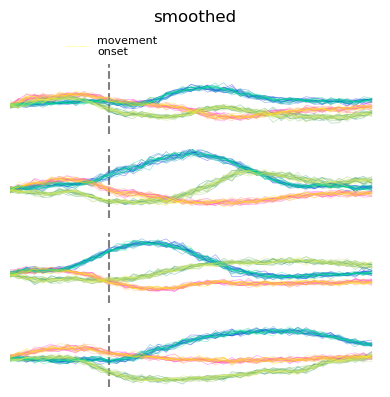

In [33]:
"""smoothed latent states"""
with torch.no_grad():
    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 4))
    fig.suptitle('smoothed\n')
    plot_utils.plot_z_samples(fig, axs, z_s_test[:, trial_list, ..., :3].cpu(), color_map_list)
    axs[0].lines[-1].set_label('movement\nonset')
    axs[0].legend(bbox_to_anchor=(0.125, 0.96), fontsize=8, frameon=False)
    plt.show()

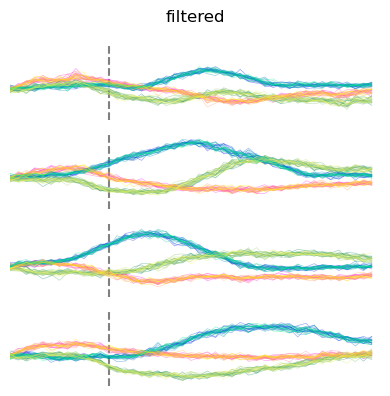

In [34]:
"""filtered latent states"""
with torch.no_grad():
    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 4))
    fig.suptitle('filtered')
    plot_utils.plot_z_samples(fig, axs, z_f_test[:, trial_list, ..., :3].cpu(), color_map_list)
    plt.show()

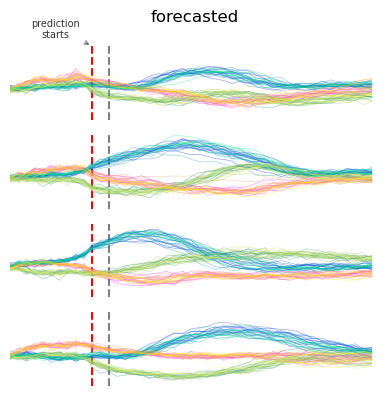

In [35]:
"""forecasted latent states"""
with torch.no_grad():
    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 4))
    fig.suptitle('forecasted')
    [axs[i].axvline(bin_prd_start, linestyle='--', color='red') for i in range(len(trial_list))]
    plot_utils.plot_z_samples(fig, axs, z_p_test[:, trial_list, ..., :3].cpu(), color_map_list)
    _, y_upper_limit = axs[0].get_ylim()
    axs[0].annotate(f"prediction\nstarts",
                      xy=(bin_prd_start, y_upper_limit),
                      xytext=(bin_prd_start - (n_bins * 0.1), (y_upper_limit * 1.2)),
                      arrowprops=dict(facecolor='black', alpha=0.4, arrowstyle='->'),
                      fontsize=7, alpha=0.8, ha='center')
    plt.show()

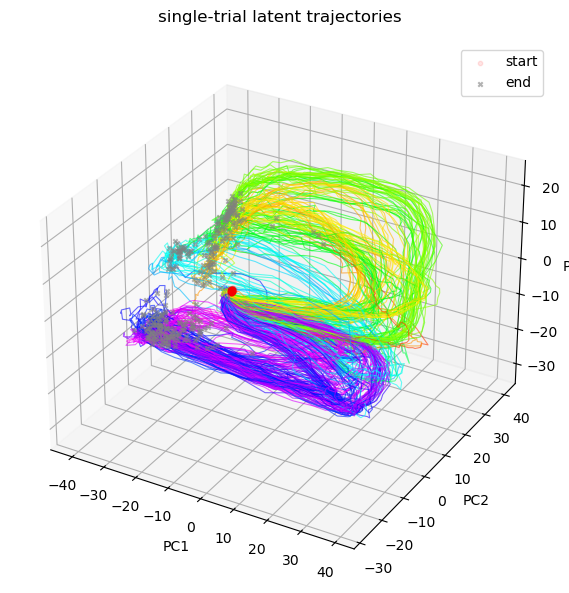

In [36]:
def plot_latents_pca_3d(z, reaches):
    z = z.mean(dim=0).cpu()
    trials, time_bins, latents = z.shape
    data_reshaped = z.view(-1, latents).cpu().numpy()
    
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data_reshaped)
    pca_result_reshaped = pca_result.reshape(trials, time_bins, 3)

    fig = plt.figure(figsize=(8, 6))
    fig.suptitle("single-trial latent trajectories", fontsize=12)
    ax = fig.add_subplot(111, projection='3d')

    for i, traj in enumerate(pca_result_reshaped):
        pos = torch.cumsum(reaches[i], dim=0).cpu()
        reach_angle = torch.atan2(pos[-1, 0], pos[-1, 1])
        reach_color = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], linewidth=0.8, alpha=0.6, color=reach_color)
        ax.scatter(traj[0, 0], traj[0, 1], traj[0, 2], color='red', marker='o', s=10, alpha=0.1, label='start' if i == 0 else "")
        ax.scatter(traj[-1, 0], traj[-1, 1], traj[-1, 2], color='gray', marker='x', s=10, alpha=0.6, label='end' if i == 0 else "")

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.legend(loc='upper right', fontsize=10)
    fig.tight_layout()
    plt.show()
    
plot_latents_pca_3d(z_f_test, vel_test)

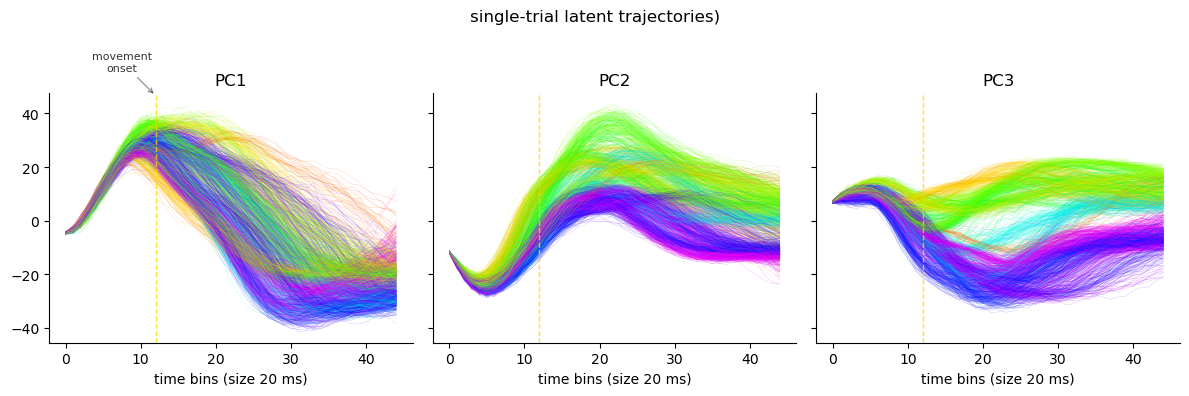

In [37]:
def plot_latents_pca_2d(z, vel, nc=3):
    z = z.mean(dim=0).cpu()
    trials, time_bins, latents = z.shape
    
    pca = PCA(n_components=nc)
    pca_result = pca.fit_transform(z.view(-1, latents).cpu().numpy())
    pca_result_reshaped = pca_result.reshape(trials, time_bins, nc)

    fig, axes = plt.subplots(1, nc, figsize=(12, 4), sharex=True, sharey=True)
    fig.suptitle("single-trial latent trajectories)", fontsize=12)

    for c in range(nc):
        for i in range(trials):
            pos = torch.cumsum(vel[i], dim=0).cpu()
            reach_angle = torch.atan2(pos[-1, 0], pos[-1, 1])
            reach_color = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)
            axes[c].plot(range(time_bins), pca_result_reshaped[i, :, c], linewidth=0.2,  alpha=0.4, color=reach_color)

        axes[c].axvline(x=move_onset_bin, color='gold', alpha=0.8, linestyle='--', linewidth=1.0)
        if c == 0:
            axes[c].annotate(f"movement\nonset",
                            xy=(move_onset_bin, axes[c].get_ylim()[1]),
                            xytext=(move_onset_bin - (n_bins*0.1), (axes[c].get_ylim()[1] * 1.2)),
                            arrowprops=dict(facecolor='black', alpha=0.4, arrowstyle='->'),
                            fontsize=8, alpha=0.8, ha='center')
            
        axes[c].spines['top'].set_visible(False)
        axes[c].spines['right'].set_visible(False)
        axes[c].set_title(f'PC{c+1}')
        axes[c].set_xlabel('time bins (size 20 ms)')

    plt.tight_layout()
    plt.show()
    
    
plot_latents_pca_2d(z_f_train, vel_train)

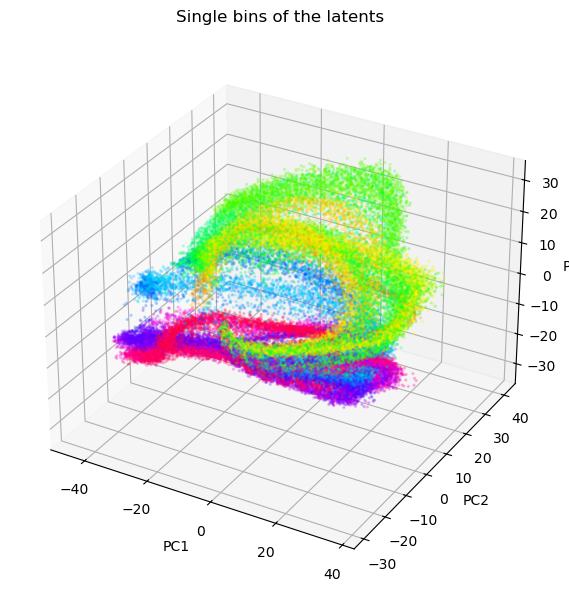

In [38]:
def plot_latent_bins_pca_3d(z, vel):
    z = z_f_train[:, :, :vel.shape[-2], :].mean(dim=0).cpu()
    trials, time_bins, latents = z.shape

    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(z.view(-1, latents).cpu().numpy())

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    fig.suptitle("Single bins of the latents", fontsize=12)

    pos = torch.cumsum(vel, dim=1).cpu()
    angles = torch.repeat_interleave(torch.atan2(pos[:, -1, 0], pos[:, -1, 1]), repeats=time_bins)

    ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
               s=2, alpha=0.2, c=angles, cmap='hsv')

    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    plt.tight_layout()
    plt.show()


plot_latent_bins_pca_3d(z_f_train, vel_train)

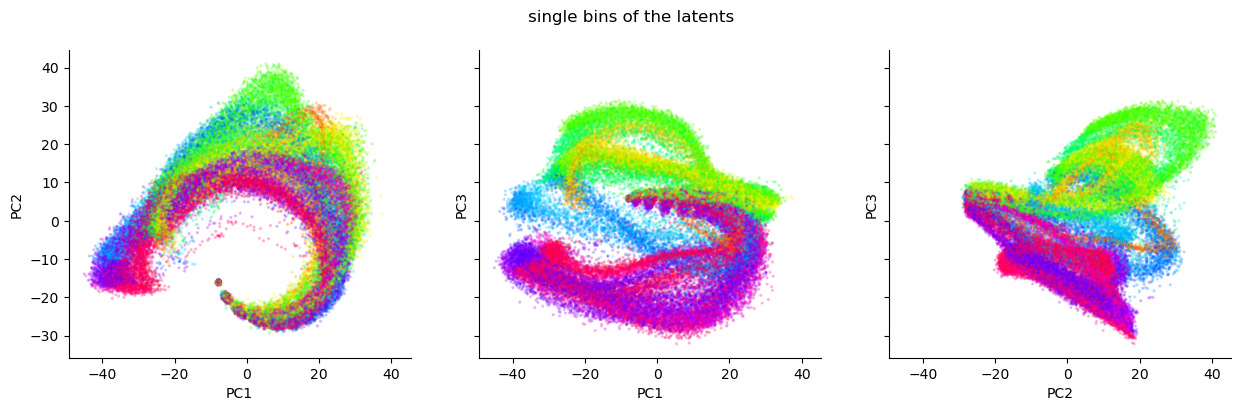

In [39]:
def plot_latent_bins_pca_2d(z, vel, nc=3):
    z = z_f_train[:, :, :vel.shape[-2], :].mean(dim=0).cpu()
    trials, time_bins, latents = z.shape

    pca = PCA(n_components=nc)
    pca_result = pca.fit_transform(z.view(-1, latents).cpu().numpy())

    fig, axes = plt.subplots(1, nc, figsize=(15, 4), sharex=True, sharey=True)
    fig.suptitle("single bins of the latents", fontsize=12)

    pos = torch.cumsum(vel, dim=1).cpu()
    reach_angle = torch.atan2(pos[:, -1, 0], pos[:, -1, 1])

    angles = torch.repeat_interleave(torch.atan2(pos[:, -1, 0], pos[:, -1, 1]), repeats=vel_train.shape[-2])

    axes[0].scatter(pca_result[:, 0], pca_result[:, 1], s=2, alpha=0.2, c=angles, cmap='hsv')
    axes[0].set_xlabel("PC1")
    axes[0].set_ylabel("PC2")

    axes[1].scatter(pca_result[:, 0], pca_result[:, 2], s=2, alpha=0.2, c=angles, cmap='hsv')
    axes[1].set_xlabel("PC1")
    axes[1].set_ylabel("PC3")

    axes[2].scatter(pca_result[:, 1], pca_result[:, 2], s=2, alpha=0.2, c=angles, cmap='hsv')
    axes[2].set_xlabel("PC2")
    axes[2].set_ylabel("PC3")
    
    for ax in fig.axes:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    plt.show()
    

plot_latent_bins_pca_2d(z_f_train, vel_train)

# Generate corresponding observations

In [41]:
rates_train_s = (cfg.bin_sz * torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s_train)).mean(dim=0)).cpu().detach().numpy()
rates_test_s = (cfg.bin_sz * torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_s_test)).mean(dim=0)).cpu().detach().numpy()
rates_test_f = (cfg.bin_sz * torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_f_test)).mean(dim=0)).cpu().detach().numpy()
rates_test_p = (cfg.bin_sz * torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_p_test)).mean(dim=0)).cpu().detach().numpy()

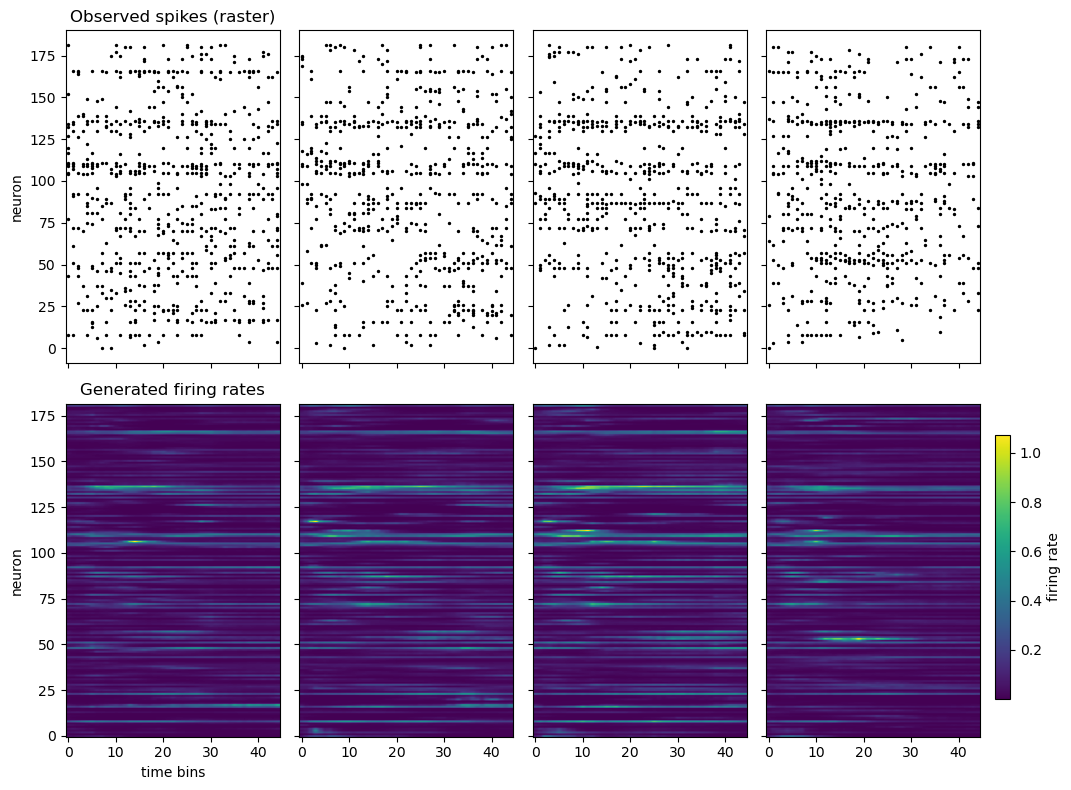

In [42]:
def plot_trials(true_rates, generated_rates, n=4, spike_threshold=0.1):
    true_rates = true_rates.cpu() if isinstance(true_rates, torch.Tensor) else true_rates
    generated_rates = generated_rates.cpu() if isinstance(generated_rates, torch.Tensor) else generated_rates

    trials = true_rates.shape[0]
    n = min(n, trials)
    random_indices = np.random.choice(trials, size=n, replace=False)

    fig, axes = plt.subplots(2, n, figsize=(2.5 * n, 8), sharex=True, sharey='row')

    for idx, trial_i in enumerate(random_indices):
        spikes = true_rates[trial_i]  # shape: [T, N]
        T, N = spikes.shape

        ax_raster = axes[0, idx]
        spike_times, neuron_ids = np.where(spikes > spike_threshold)
        ax_raster.scatter(spike_times, neuron_ids, s=2, color='black')
        if idx == 0:
            ax_raster.set_ylabel("neuron")

        ax_gen = axes[1, idx]
        im = ax_gen.imshow(generated_rates[trial_i].T, aspect='auto', cmap='viridis', origin='lower')
        if idx == 0:
            ax_gen.set_ylabel("neuron")
            ax_gen.set_xlabel("time bins")

    cbar_ax = fig.add_axes([1., 0.12, 0.015, 0.33])  # [left, bottom, width, height]
    fig.colorbar(im, cax=cbar_ax, label="firing rate")

    axes[0, 0].set_title("Observed spikes (raster)", fontsize=12)
    axes[1, 0].set_title("Generated firing rates", fontsize=12)

    plt.tight_layout()
    plt.show()

plot_trials(y_test_obs, rates_test_s)

# Reconstructed single-neuron firing rates

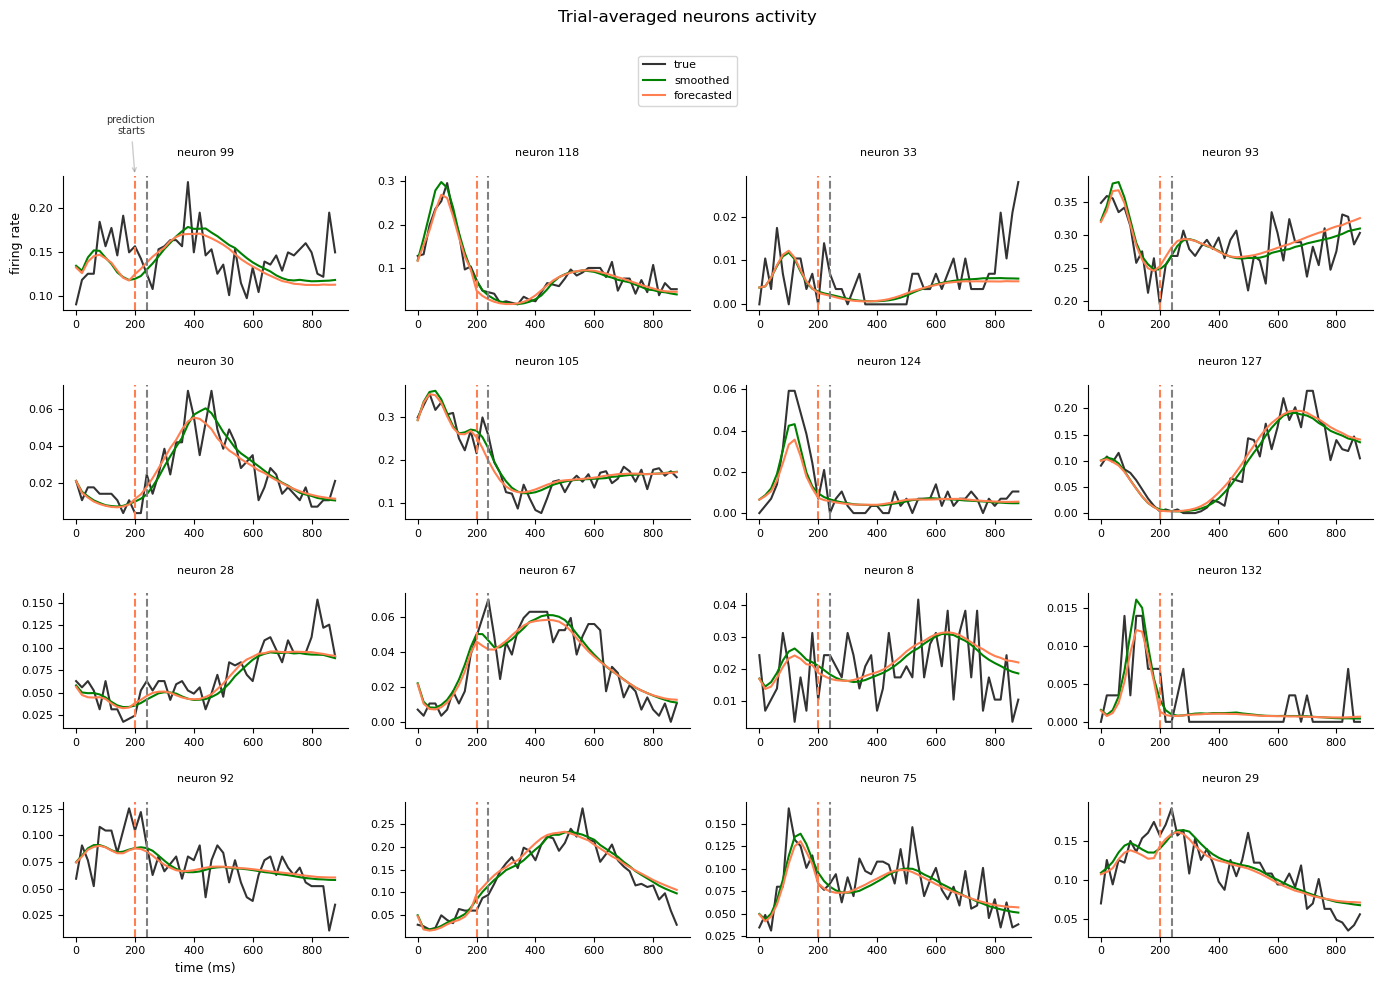

In [44]:
n_neurons_to_plot = 16
neuron_indcs = np.random.choice(range(0, y_test_obs.shape[2]), size=n_neurons_to_plot, replace=False)

fig, axes = plt.subplots(int(np.sqrt(n_neurons_to_plot)), int(np.sqrt(n_neurons_to_plot)), figsize=(14, 10))
fig.suptitle(f'Trial-averaged neurons activity\n\n\n\n')

for ax, neuron in zip(axes.flat, neuron_indcs):

    fr_data = torch.mean(y_test_obs[:, :, neuron], axis=0).cpu()
    fr_model_s = torch.mean(torch.from_numpy(rates_test_s[:, :, neuron]), axis=0)
    fr_model_p = torch.mean(torch.from_numpy(rates_test_p[:, :, neuron]), axis=0)

    ax.plot(np.arange(n_bins) * cfg.bin_sz_ms, fr_data, color= 'black', alpha=0.8, label='true' if neuron == neuron_indcs[-1] else '')
    ax.plot(np.arange(n_bins) * cfg.bin_sz_ms, fr_model_s, color= 'green', alpha=1.0, label='smoothed' if neuron == neuron_indcs[-1] else '')
    ax.plot(np.arange(n_bins) * cfg.bin_sz_ms, fr_model_p, color= 'coral', alpha=1.0, label='forecasted' if neuron == neuron_indcs[-1] else '')

    ax.axvline(bin_prd_start * cfg.bin_sz_ms, linestyle='--', color= 'coral')
    ax.axvline(move_onset_bin * cfg.bin_sz_ms, linestyle='--', color= 'gray')

    if neuron == neuron_indcs[0]:
      _, y_upper_limit = ax.get_ylim()
      ax.annotate(f"prediction\nstarts",
                      xy=(bin_prd_start * cfg.bin_sz_ms, y_upper_limit),
                      xytext=(bin_prd_start * cfg.bin_sz_ms - (n_bins * 0.3), (y_upper_limit * 1.2)),
                      arrowprops=dict(facecolor='black', alpha=0.2, arrowstyle='->'),
                      fontsize=7, alpha=0.8, ha='center')

    ax.set_title(f'\nneuron {neuron+1}\n', fontsize=8)
    ax.set_xlabel('time (ms)' if neuron == neuron_indcs[-int(np.sqrt(n_neurons_to_plot))] else '', fontsize=9)
    ax.set_ylabel('firing rate' if neuron == neuron_indcs[0] else '', fontsize=9)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.94), ncol=1, fontsize=8)
fig.tight_layout()


plt.show()

# Decoding hand kinematics

In [46]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

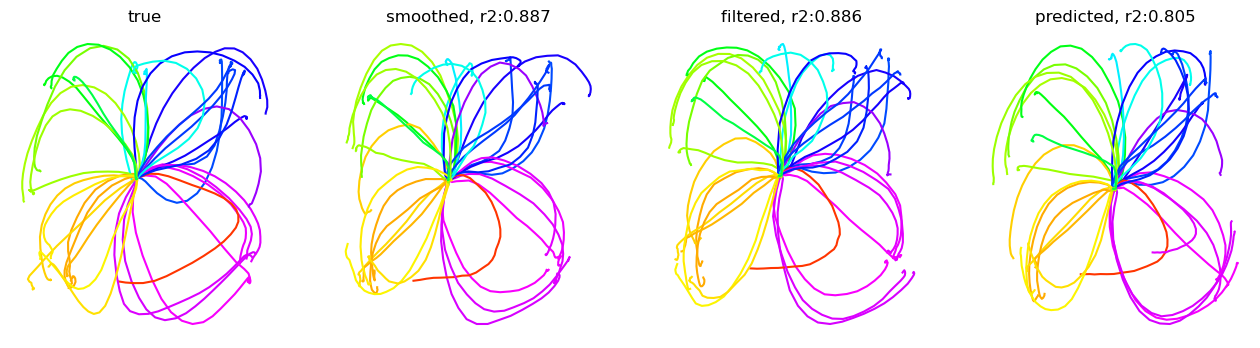

In [47]:
"""velocity decoder"""

with torch.no_grad():
    clf = Ridge(alpha=0.01)

    clf.fit(rates_train_s[:, :n_bins_enc, :].reshape(-1, n_neurons_obs), vel_train.cpu().reshape(-1, 2))
    r2 = clf.score(rates_train_s[:, :n_bins_enc, :].reshape(-1, n_neurons_obs), vel_train.cpu().reshape(-1, 2))

    pred_reshape = lambda rates, clf, original_shape: clf.predict(rates[:, :n_bins_enc, :].reshape(-1, n_neurons_obs)).reshape(list(original_shape)[:-1] + [2])
    calc_r2 = lambda rates, clf, true_velocity: clf.score(rates[:, :n_bins_enc, :].reshape(-1, n_neurons_obs), true_velocity.cpu().reshape(-1, 2))

    r2_test_s = calc_r2(rates_test_s, clf, vel_test)
    r2_test_f = calc_r2(rates_test_f, clf, vel_test)
    r2_test_p = calc_r2(rates_test_p, clf, vel_test)

    vel_hat_test_s = pred_reshape(rates_test_s, clf, vel_test.shape)
    vel_hat_test_f = pred_reshape(rates_test_f, clf, vel_test.shape)
    vel_hat_test_p = pred_reshape(rates_test_p, clf, vel_test.shape)

n_trials_test = vel_test.shape[0]
n_trials_plot = 35

vel_to_pos = lambda v: torch.cumsum(torch.tensor(v).clone().detach().to('cpu'), dim=1)

pos_test = vel_to_pos(vel_test.cpu())
trial_plt_dx = torch.randperm(n_trials_test)[:n_trials_plot]
reach_angle = torch.atan2(pos_test[:, -1, 0], pos_test[:, -1, 1])
reach_colors = plt.cm.hsv(reach_angle / (2 * np.pi) + 0.5)

pos_test_hat_s = vel_to_pos(vel_hat_test_s)
pos_test_hat_f = vel_to_pos(vel_hat_test_f)
pos_test_hat_p = vel_to_pos(vel_hat_test_p)

with torch.no_grad():
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    plot_utils.plot_reaching(axs[0], pos_test[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[1], pos_test_hat_s[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[2], pos_test_hat_f[trial_plt_dx], reach_colors[trial_plt_dx])
    plot_utils.plot_reaching(axs[3], pos_test_hat_p[trial_plt_dx], reach_colors[trial_plt_dx])

    axs[0].set_title('true')
    axs[1].set_title(f'smoothed, r2:{r2_test_s:.3f}')
    axs[2].set_title(f'filtered, r2:{r2_test_f:.3f}')
    axs[3].set_title(f'predicted, r2:{r2_test_p:.3f}')

    plt.show()

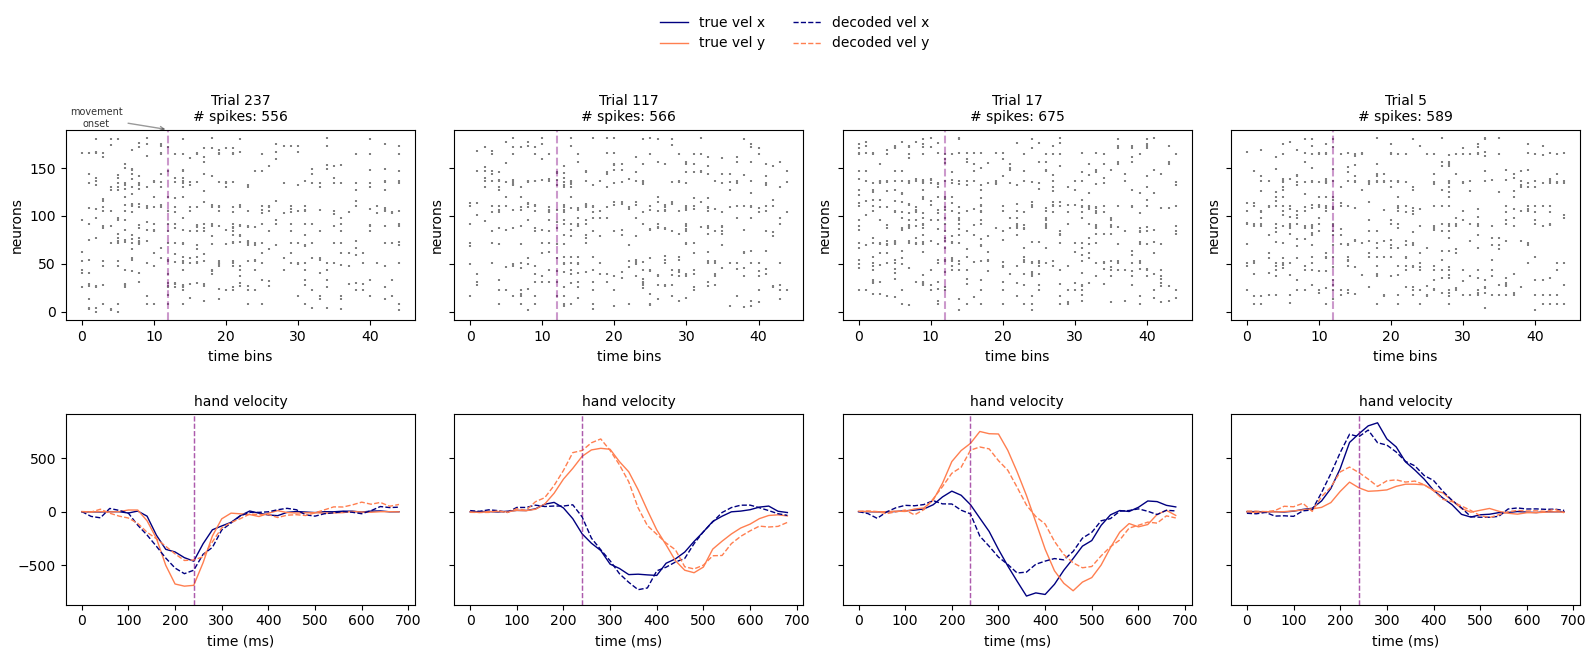

In [48]:
def plot_spikes_and_decoded_behavior(spikes, velocity, velocity_hat, binsize, trials_inds, event_bin):
    n_trials = len(trials_inds)
    fig, axes = plt.subplots(nrows=2, ncols=n_trials, figsize=(4 * n_trials, 6), sharex=False, sharey='row')
    if n_trials == 1:
        axes = axes.reshape(2, 1)

    for col, trial_idx in enumerate(trials_inds):
        trial = spikes[trial_idx]
        reach = velocity[trial_idx]
        decoded_reach = velocity_hat[trial_idx]
        ax_spikes = axes[0, col]
        ax_vel = axes[1, col]

        for neuron_idx in range(trial.shape[-1]):
            spike_times = np.where(trial[:, neuron_idx].cpu() == 1)[0]
            ax_spikes.scatter(spike_times, [neuron_idx] * len(spike_times), s=4, color='gray', marker='|')

        ax_spikes.axvline(x=event_bin, linestyle='--', color='purple', alpha=0.4)
        ax_spikes.set_ylabel('neurons')
        ax_spikes.set_title(f'\nTrial {trial_idx}\n# spikes: {int(torch.sum(trial))}', fontsize=10)
        ax_spikes.set_xlabel('time bins')
        
        # True reaches
        time_axis = torch.arange(reach.shape[0]) * binsize
        ax_vel.plot(time_axis, reach[:, 0], color='navy', linewidth=1.0, label='true vel x' if col == 0 else '')
        ax_vel.plot(time_axis, reach[:, 1], color='coral', linewidth=1.0, label='true vel y' if col == 0 else '')
        ax_vel.axvline(x=event_bin * binsize, linestyle='--', linewidth=1.0, color='purple', alpha=0.4)
        ax_vel.set_xlabel('time (ms)')
        ax_vel.set_title('\nhand velocity', fontsize=10)
        
        # Decoded reaches
        time_axis = torch.arange(reach.shape[0]) * binsize
        ax_vel.plot(time_axis, decoded_reach[:, 0], linestyle='--', linewidth=1.0, color='navy', label='decoded vel x' if col == 0 else '')
        ax_vel.plot(time_axis, decoded_reach[:, 1], linestyle='--', linewidth=1.0, color='coral', label='decoded vel y' if col == 0 else '')
        ax_vel.axvline(x=event_bin * binsize, linestyle='--', linewidth=1.0, color='purple', alpha=0.4)

        if col == 0:
            _, y_top = ax_spikes.get_ylim()
            ax_spikes.annotate("movement\nonset", xy=(event_bin, y_top), xytext=(event_bin - 10, y_top + 3),
                               arrowprops=dict(facecolor='black', alpha=0.4, arrowstyle='->'),
                               fontsize=7, ha='center', alpha=0.8)

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=10, frameon=False)

    fig.tight_layout()
    plt.show()


plot_spikes_and_decoded_behavior(y_test_obs.cpu(), vel_test.cpu(), vel_hat_test_s, cfg.bin_sz_ms,
                                 torch.randperm(y_test_obs.size(0))[:4],
                                 event_bin=move_onset_bin,)

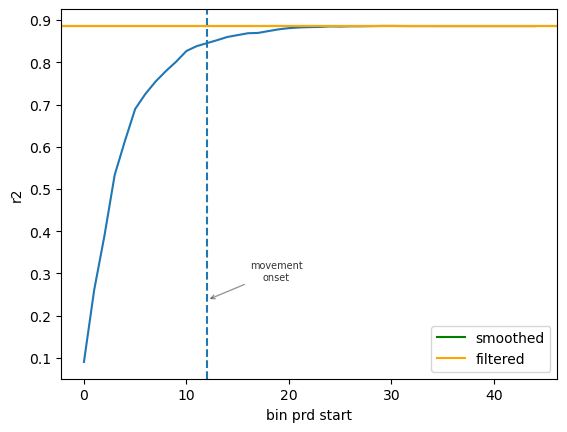

In [49]:
with torch.no_grad():

    r2_k_step = []
    for k in range(n_bins):

        z_prd_test = utils.propagate_latent_k_steps(z_f_test[:, :, k], dynamics_mod, n_bins - (k + 1))
        z_prd_test = torch.concat([z_f_test[:, :, :k], z_prd_test], dim=2)

        rates_prd_test = cfg.bin_sz * torch.exp(seq_vae.ssm.likelihood_pdf.readout_fn(z_prd_test)).mean(dim=0).cpu().detach().numpy()
        r2_prd = calc_r2(rates_prd_test, clf, vel_test)
        r2_k_step.append(r2_prd)

plt.axvline(move_onset_bin, linestyle='--')
plt.annotate(f"movement\nonset",
             xy=(move_onset_bin, y_upper_limit),
             xytext=(move_onset_bin + (n_bins * 0.15), (y_upper_limit * 1.2)),
             arrowprops=dict(facecolor='black', alpha=0.4, arrowstyle='->'),
             fontsize=7, alpha=0.8, ha='center')

plt.plot(r2_k_step)
plt.axhline(r2_test_s, color='green', label='smoothed')
plt.axhline(r2_test_f, color='orange', label='filtered')
plt.xlabel('bin prd start')
plt.ylabel('r2')
plt.legend()
plt.show()

Evaluating how well future hand velocity can be decoded from the model's predictions when starting the prediction from different points in the trial (k). This analysis assesses how the model's ability to forecast the remaining hand movement changes depending on how much of the initial trial data it has observed.

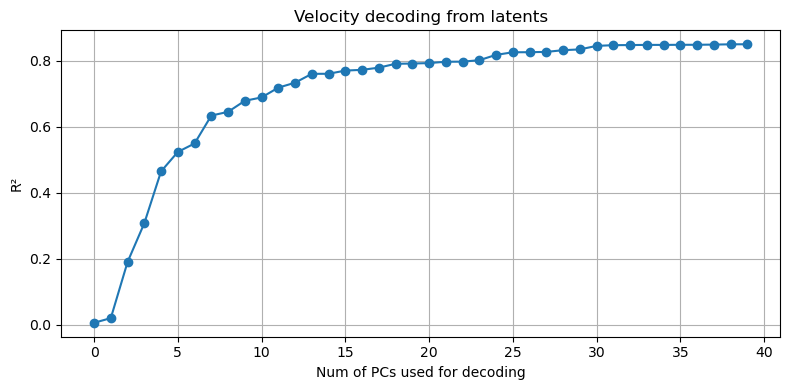

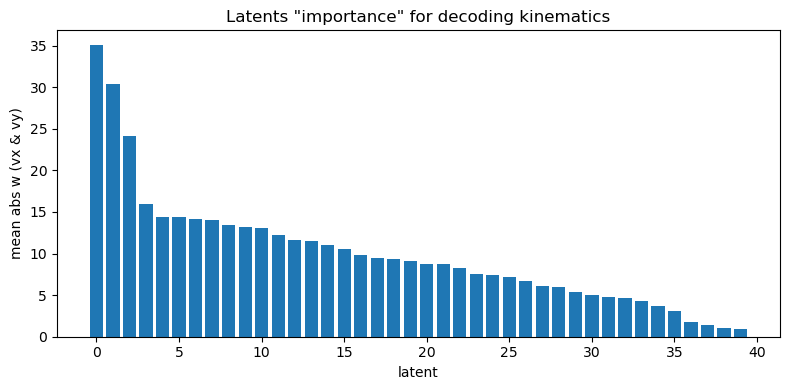

In [51]:
def pca_vs_r2_plot(z_train, z_test, vel_train, vel_test, max_pcs=30, alpha=0.01):
    def flatten(x):
        return x.reshape(-1, x.shape[2]).detach().cpu().numpy()

    def flatten_vel(v):
        return v.reshape(-1, 2).detach().cpu().numpy()

    X_train = flatten(z_train)
    X_test = flatten(z_test)
    y_train = flatten_vel(vel_train)
    y_test = flatten_vel(vel_test)

    r2_scores = []

    for k in range(1, max_pcs + 1):
        pca = PCA(n_components=k)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        clf = Ridge(alpha=alpha)
        clf.fit(X_train_pca, y_train)

        y_pred = clf.predict(X_test_pca)
        r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
        r2_scores.append(r2)

    def plot_sorted_unit_tuning(ridge_clf, title='Latents "importance" for decoding kinematics'):
        weights = ridge_clf.coef_

        unit_importance = np.abs(weights).mean(axis=0)  # shape: (units,)
        sorted_indices = np.argsort(-unit_importance)  # descending order
        sorted_importance = unit_importance[sorted_indices]

        plt.figure(figsize=(8, 4))
        plt.bar(np.arange(len(sorted_importance)), sorted_importance)
        plt.xlabel('latent')
        plt.ylabel('mean abs w (vx & vy)')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    pcs = np.arange(max_pcs)
    plt.figure(figsize=(8, 4))
    plt.plot(pcs, r2_scores, marker='o')
    plt.xlabel("Num of PCs used for decoding")
    plt.ylabel("R²")
    plt.title("Velocity decoding from latents")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plot_sorted_unit_tuning(clf)

    return np.array(r2_scores)


r2_scores = pca_vs_r2_plot(z_s_train[:, :, :n_bins_enc, :].mean(dim=0), z_s_test[:, :, :n_bins_enc, :].mean(dim=0), vel_train, vel_test, max_pcs=40)

# Predictive log-likelihood

In [53]:
def predictive_log_likelihood(spikes, rates):
    eps = 1e-8
    spikes = torch.tensor(spikes, dtype=torch.float32)
    rates = torch.tensor(rates, dtype=torch.float32)

    log_likelihood = spikes * torch.log(rates + eps) - rates
    return log_likelihood.sum(dim=-1)


I, T, N = y_test_obs.shape

ll_filter = predictive_log_likelihood(y_test_obs.cpu(), rates_test_s).numpy()
mean_filter = ll_filter.mean(axis=0)
sem_filter = ll_filter.std(axis=0) / np.sqrt(I)

ll_smooth = predictive_log_likelihood(y_test_obs.cpu(), rates_test_f).numpy()
mean_smooth = ll_smooth.mean(axis=0)
sem_smooth = ll_smooth.std(axis=0) / np.sqrt(I)

ll_forecast = predictive_log_likelihood(y_test_obs.cpu(), rates_test_p).numpy()
mean_forecast = ll_forecast.mean(axis=0)
sem_forecast = ll_forecast.std(axis=0) / np.sqrt(I)

# Mean firing rate per neuron as a baseline
mean_rate_per_neuron = y_test_obs.mean(dim=(0, 1))
baseline_rates = mean_rate_per_neuron.unsqueeze(0).unsqueeze(0).expand(I, T, N)

ll_baseline = predictive_log_likelihood(y_test_obs, baseline_rates)
mean_base = ll_baseline.mean(dim=0).cpu().numpy()
sem_base = ll_baseline.std(dim=0).cpu().numpy() / np.sqrt(I)

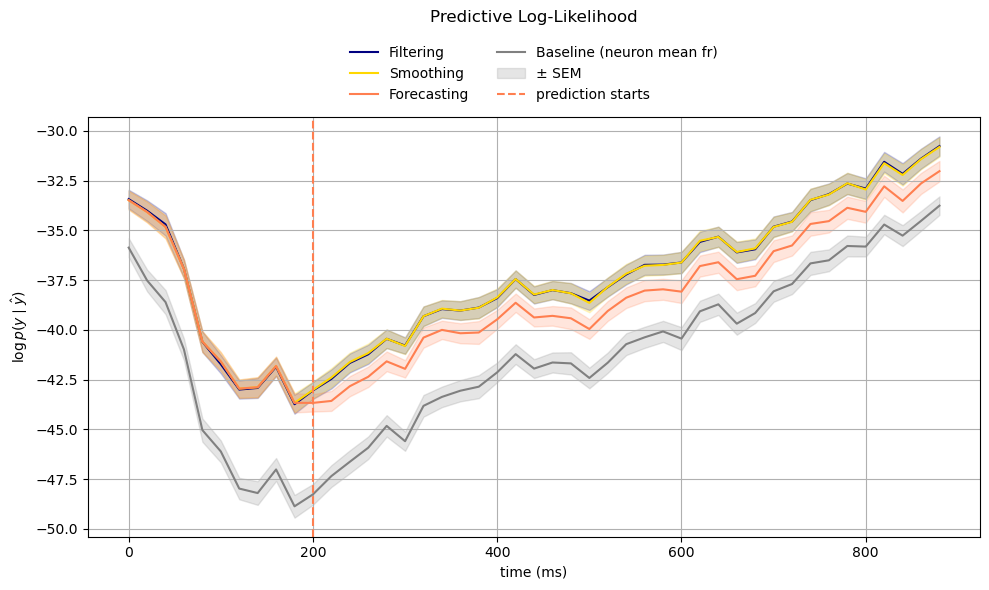

In [54]:
time = np.arange(T) * cfg.bin_sz_ms

plt.figure(figsize=(10, 6))

plt.plot(time, ll_filter.mean(0), label='Filtering', color='navy')
plt.fill_between(time, mean_filter - sem_filter, mean_filter + sem_filter, color='navy', alpha=0.2)

plt.plot(time, ll_smooth.mean(0), label='Smoothing', color='gold')
plt.fill_between(time, mean_smooth - sem_smooth, mean_smooth + sem_smooth, color='gold', alpha=0.2)

plt.plot(time, ll_forecast.mean(0), label='Forecasting', color='coral')
plt.fill_between(time, mean_forecast - sem_forecast, mean_forecast + sem_forecast, color='coral', alpha=0.2)

plt.plot(time, mean_base, label='Baseline (neuron mean fr)', color='gray')
plt.fill_between(time,  mean_base - sem_base, mean_base + sem_base, color='gray', alpha=0.2, label='± SEM')

plt.axvline(bin_prd_start * cfg.bin_sz_ms, linestyle='--', color='coral', label='prediction starts')

plt.xlabel('time (ms)')
plt.ylabel(r'$\log p(y \mid \hat{y})$')
plt.title('Predictive Log-Likelihood\n\n\n\n\n')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2, fontsize='medium', frameon=False)
plt.grid(True)
plt.tight_layout()
plt.show()